In [ ]:
import pandas as pd
import numpy as np


# Load the dataset
df = pd.read_csv("/content/Crime_Data_from_2020_to_Present (3).csv")
print(df.shape)

#  Standardize column names
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace(r'[^a-z0-9_]', '', regex=True)


# Handle missing values
cat_cols = df.select_dtypes(include=['object']).columns
num_cols = df.select_dtypes(include=[np.number]).columns


# Fill missing values or col
df[cat_cols] = df[cat_cols].fillna('UNKNOWN')
for col in num_cols:
    if df[col].isna().sum() > 0:
        median_val = df[col].median()
        df[col] = df[col].fillna(median_val)


(1004991, 28)


In [ ]:
print(df.columns)

Index(['dr_no', 'date_rptd', 'date_occ', 'time_occ', 'area', 'area_name',
       'rpt_dist_no', 'part_12', 'crm_cd', 'crm_cd_desc', 'mocodes',
       'vict_age', 'vict_sex', 'vict_descent', 'premis_cd', 'premis_desc',
       'weapon_used_cd', 'weapon_desc', 'status', 'status_desc', 'crm_cd_1',
       'crm_cd_2', 'crm_cd_3', 'crm_cd_4', 'location', 'cross_street', 'lat',
       'lon'],
      dtype='object')


In [ ]:
print(len(df))

1004991


##1. Importing Necessary Libraries


In [ ]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt



##2. Research Question Based Preprocessing

In [ ]:



# Retaining relevant columns
cols = ['date_occ', 'area_name', 'crm_cd_desc']
df = df[cols].dropna()

# Convert to date_occ to datetime format
df['date_occ'] = pd.to_datetime(df['date_occ'], errors='coerce')
df = df.dropna(subset=['date_occ'])

# Extract month attribute- base for aggregation
df['month'] = df['date_occ'].dt.to_period('M')

# Aggregartion of crime counts based on area-month aggregation
crime_counts = (
    df.groupby(['area_name', 'month', 'crm_cd_desc'])
      .size()
      .reset_index(name='Count')
)

# Converting to wideformat
crime_pivot = (
    crime_counts
    .pivot_table(index=['area_name', 'month'],
                 columns='crm_cd_desc',
                 values='Count',
                 fill_value=0)
)

print("\n Aggregated dataset ready for PCA")
print("Shape:", crime_pivot.shape)

/tmp/ipython-input-357370161.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date_occ'] = pd.to_datetime(df['date_occ'], errors='coerce')



 Aggregated dataset ready for PCA
Shape: (1302, 140)


##3.Standardizing the data

In [ ]:
#Standardizing the data from crime_pivot
scaler = StandardScaler()
X_scaled = scaler.fit_transform(crime_pivot)



##4. Applying PCA

In [ ]:
# Applying PCA - using the PCA function in python
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)
X_reconstructed = pca.inverse_transform(X_pca)



##5. Computing Reconstruction error and ispecting the range

In [ ]:
## Calculating the reconstruction error
reconstruction_error = np.mean((X_scaled - X_reconstructed) ** 2, axis=1)
crime_pivot['Reconstruction_Error'] = reconstruction_error

#Analyzing the limits of the reconstruction error
#measures how good the performance of the PCA is
print("\n Reconstruction Error Summary:")
print("Minimum Error:", np.min(reconstruction_error))
print("Maximum Error:", np.max(reconstruction_error))
print("Mean Error:", np.mean(reconstruction_error))
print("Median Error:", np.median(reconstruction_error))
print("Standard Deviation:", np.std(reconstruction_error))

# Percentiles to understand distribution
for p in [50, 75, 90, 95, 99]:
    print(f"{p}th Percentile:", np.percentile(reconstruction_error, p))






 Reconstruction Error Summary:
Minimum Error: 0.0024735597967969003
Maximum Error: 0.28325302328129487
Mean Error: 0.04750910662161951
Median Error: 0.04585389103849834
Standard Deviation: 0.026283599563434387
50th Percentile: 0.04585389103849834
75th Percentile: 0.06110174992117508
90th Percentile: 0.07747586933914656
95th Percentile: 0.09420657012075997
99th Percentile: 0.1306294594516692


##6. Identifying and Displaying Anomalies

In [ ]:
# Identifying top 5% of the anomalies
threshold = np.percentile(reconstruction_error, 95)
crime_pivot['Anomaly'] = (reconstruction_error > threshold).astype(int)

# Resetting the index back to area and month
crime_pivot = crime_pivot.reset_index()

#Displaying the top 10 of ther anomalies using the head function
anomalies = crime_pivot[crime_pivot['Anomaly'] == 1]
print("\n Top 10 detected anomalies:")
print(anomalies[['area_name', 'month', 'Reconstruction_Error']].sort_values(by='Reconstruction_Error', ascending=False).head(10))




 Top 10 detected anomalies:
crm_cd_desc    area_name    month  Reconstruction_Error
968            Southwest  2023-08              0.283253
87               Central  2022-03              0.173249
983            Southwest  2024-11              0.166592
92               Central  2022-08              0.165897
746              Pacific  2020-06              0.163286
982            Southwest  2024-10              0.143764
749              Pacific  2020-09              0.143398
94               Central  2022-10              0.140895
43           77th Street  2023-08              0.139535
899            Southeast  2023-01              0.138387


##7. Plot generation

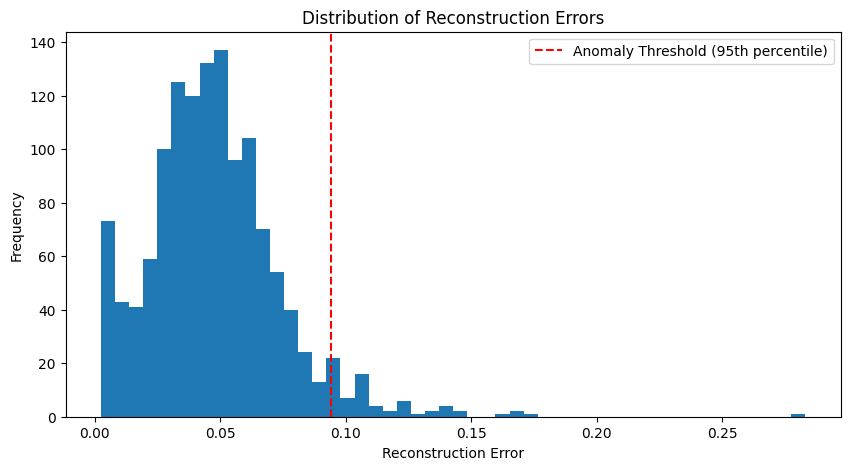

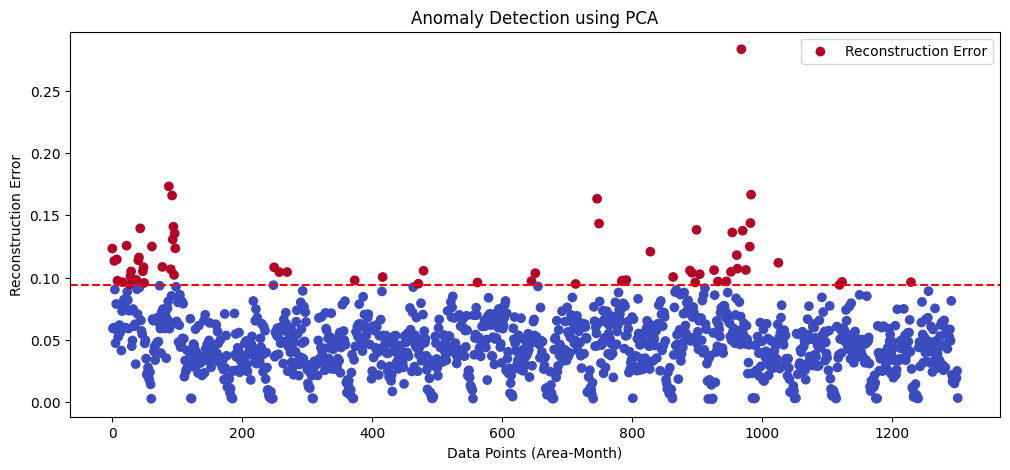


 Approx. baseline accuracy (non-anomalous fraction): 0.949


In [ ]:
# Create anomaly label - useful for plotting
crime_pivot['Anomaly'] = (reconstruction_error > threshold).astype(int)

# Plot 1 — distribution of reconstruction errors
plt.figure(figsize=(10,5))
plt.hist(reconstruction_error, bins=50)
plt.axvline(threshold, color='r', linestyle='--', label='Anomaly Threshold (95th percentile)')
plt.title('Distribution of Reconstruction Errors')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Plot 2 — anomalies by month
plt.figure(figsize=(12,5))
plt.scatter(range(len(reconstruction_error)), reconstruction_error,
            c=crime_pivot['Anomaly'], cmap='coolwarm', label='Reconstruction Error')
plt.axhline(threshold, color='r', linestyle='--')
plt.title('Anomaly Detection using PCA')
plt.xlabel('Data Points (Area-Month)')
plt.ylabel('Reconstruction Error')
plt.legend()
plt.show()

# Simple baseline accuracy
predicted_labels = crime_pivot['Anomaly']
accuracy = 1 - (sum(predicted_labels) / len(predicted_labels))
print(f"\n Approx. baseline accuracy (non-anomalous fraction): {accuracy:.3f}")
